In [ ]:
!pip install albumentations opencv-python
!pip install matplotlib
!pip install gradio

In [11]:
from pathlib import Path
import os
import cv2
import albumentations as A
import glob
import matplotlib.pyplot as plt
import gradio as gr
import os
import cv2
from glob import glob

In [3]:
in_colab = False
data_processed = True
eda = False
DRIVE_BASE_DIR = '/content/drive'

In [4]:
if in_colab:
    # Mount Google Drive
    from google.colab import drive
    drive.mount(DRIVE_BASE_DIR)

In [5]:
# Path to where your data is stored
if in_colab:
    DATA_DIR = Path('/content/drive/MyDrive/Lacuna')
else:
    DATA_DIR = Path('./')

# Preview data files available
os.listdir(DATA_DIR)

['.augment-env',
 '.venv',
 'benchmark_submission.csv',
 'benchmark_submission1.csv',
 'benchmark_submission10.csv',
 'benchmark_submission10last.csv',
 'benchmark_submission4.csv',
 'benchmark_submission5.csv',
 'benchmark_submission7.csv',
 'benchmark_submission8.csv',
 'data.yaml',
 'datasets',
 'images',
 'images.zip',
 'image_augmentation.ipynb',
 'Lacuna_Malaria_Detection_Challenge.ipynb',
 'manifest-c922911ae9101743fc37dc64723c2ee220240829-19463-18lbi0k.json',
 'poetry.lock',
 'pyproject.toml',
 'runs',
 'SampleSubmission.csv',
 'Test.csv',
 'Train.csv',
 'yolo11m.pt',
 'yolo11n.pt',
 'yolov10n.pt',
 'yolov8n.pt']

In [8]:
# Images directories
DATASET_DIR = Path(DATA_DIR / 'datasets/dataset')
IMAGES_DIR = DATASET_DIR / 'images'
TRAIN_IMAGES_DIR = IMAGES_DIR / 'train'
VAL_IMAGES_DIR = IMAGES_DIR / 'val'
TEST_IMAGES_DIR = IMAGES_DIR / 'test'

# Labels directories
LABELS_DIR = DATASET_DIR / 'labels'
TRAIN_LABELS_DIR = LABELS_DIR / 'train'
VAL_LABELS_DIR = LABELS_DIR / 'val'
TEST_LABELS_DIR = LABELS_DIR / 'test'

In [ ]:
# Define paths
# For training
images_dir = TRAIN_IMAGES_DIR
labels_dir = TRAIN_LABELS_DIR
# # # For validation
# images_dir = VAL_IMAGES_DIR
# labels_dir = VAL_LABELS_DIR
# # # For testing data
# images_dir = TEST_IMAGES_DIR
# labels_dir = TEST_LABELS_DIR
# For aug
# Do this so that we can make the training data big
augmented_images_dir = DATASET_DIR / "aug" / "images" / "train"
augmented_labels_dir = DATASET_DIR / "aug" / "labels" / "train"


# Create output directories if they don’t exist
os.makedirs(augmented_images_dir, exist_ok=True)
os.makedirs(augmented_labels_dir, exist_ok=True)

# Define Albumentations augmentation pipeline
augmentation_pipeline = A.Compose([
    A.RandomRotate90(),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    # Other methods of augmentation we can use
    # A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
    # A.GaussianBlur(blur_limit=(3, 7)),
    # A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20)
], bbox_params=A.BboxParams(format='yolo', min_visibility=1.0, label_fields=['class_labels']))

# Function to read YOLO labels
def read_yolo_labels(label_path):
    with open(label_path, 'r') as file:
        labels = [line.strip().split() for line in file.readlines()]
    return [(int(label[0]), float(label[1]), float(label[2]), float(label[3]), float(label[4])) for label in labels]

# Function to save YOLO labels
def save_yolo_labels(label_path, labels):
    with open(label_path, 'w') as file:
        for label in labels:
            file.write(f"{label[0]} {label[1]:.6f} {label[2]:.6f} {label[3]:.6f} {label[4]:.6f}\n")

# Get all image paths
image_paths = glob.glob(os.path.join(images_dir, "*.jpg"))
label_paths = {os.path.splitext(os.path.basename(p))[0]: p for p in glob.glob(os.path.join(labels_dir, "*.txt"))}

# Count class occurrences to balance dataset
class_counts = {}
for label_file in label_paths.values():
    labels = read_yolo_labels(label_file)
    for label in labels:
        class_id = label[0]
        class_counts[class_id] = class_counts.get(class_id, 0) + 1

# Define desired augmentation ratio (e.g., 2x the original dataset size)
augmentation_ratio = 3
augmented_per_class = {cls: 0 for cls in class_counts.keys()}

# Augment and save images and labels
for image_path in image_paths:
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    label_path = label_paths.get(image_name)
    try:
        if not label_path:
            continue

        # Read image and labels
        image = cv2.imread(image_path)
        labels = read_yolo_labels(label_path)

        # Convert labels to Albumentations format
        bboxes = [label[1:] for label in labels]  # YOLO format (x, y, width, height)
        class_labels = [label[0] for label in labels]  # Class IDs

        # Apply augmentations while balancing classes
        for i in range(augmentation_ratio - 1):
            augmented = augmentation_pipeline(image=image, bboxes=bboxes, class_labels=class_labels)
            aug_image = augmented["image"]

            # Clip bounding boxes to the range [0, 1] and filter by min_visibility and min_area
            aug_bboxes = [
                (
                    max(0.0, min(1.0, bbox[0])),  # x_center
                    max(0.0, min(1.0, bbox[1])),  # y_center
                    max(0.0, min(1.0, bbox[2])),  # width
                    max(0.0, min(1.0, bbox[3]))   # height
                )
                for bbox in augmented["bboxes"]
            ]
            aug_class_labels = augmented["class_labels"]

            # Reformat augmented labels back to YOLO format
            aug_labels = [(aug_class_labels[j], *aug_bboxes[j]) for j in range(len(aug_bboxes))]

            # Skip saving if there’s no augmentation needed for balance
            for label in aug_labels:
                class_id = label[0]
                if augmented_per_class[class_id] < augmentation_ratio * class_counts[class_id]:
                    augmented_per_class[class_id] += 1
                else:
                    continue

            # Save augmented image and label
            aug_image_name = f"{image_name}_aug_{i}.jpg"
            aug_label_name = f"{image_name}_aug_{i}.txt"
            cv2.imwrite(os.path.join(augmented_images_dir, aug_image_name), aug_image)
            save_yolo_labels(os.path.join(augmented_labels_dir, aug_label_name), aug_labels)
    except Exception as e:
        print('image_name', image_name)
        print('label_path', label_path)
        print('error', e)

## Testing Transformation Pipeline

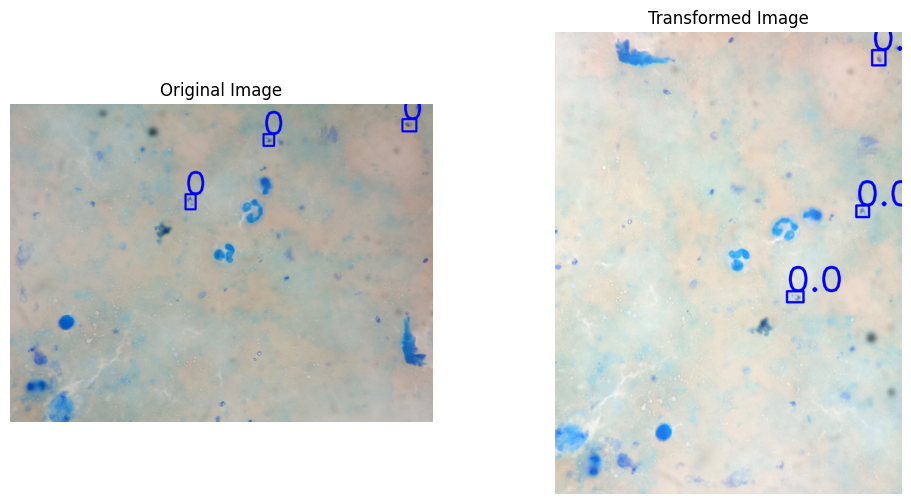

In [46]:
# Apply transformations
transformed = augmentation_pipeline(image=image, bboxes=bboxes, class_labels=class_labels)

# Extract transformed image and bounding boxes
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']
transformed_labels = transformed['class_labels']

# Define label colors if needed
label_colors = {'Trophozoite': (255, 0, 0), 'WBC': (0, 255, 0), 'NEG': (0, 0, 255)}

# Function to plot an image with bounding boxes
def plot_image_with_bboxes(ax, image, bboxes, labels, label_colors=None):
    img_copy = image.copy()
    for i, bbox in enumerate(bboxes):
        # Convert YOLO format (x_center, y_center, width, height) to coordinates
        x_center, y_center, width, height = bbox
        x_min = int((x_center - width / 2) * img_copy.shape[1])
        y_min = int((y_center - height / 2) * img_copy.shape[0])
        x_max = int((x_center + width / 2) * img_copy.shape[1])
        y_max = int((y_center + height / 2) * img_copy.shape[0])

        # Define color for each class, with a fallback color if label is not in label_colors
        color = label_colors.get(labels[i], (255, 0, 0))  # Default to red if label not found

        # Draw bounding box and label on the image
        cv2.rectangle(img_copy, (x_min, y_min), (x_max, y_max), color, 20)
        cv2.putText(img_copy, str(labels[i]), (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 10, color, 25)

    ax.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    ax.axis('off')

# Plot original and transformed images side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original image with bounding boxes
plot_image_with_bboxes(axs[0], image, bboxes, class_labels, label_colors)
axs[0].set_title("Original Image")

# Plot the transformed image with bounding boxes
plot_image_with_bboxes(axs[1], transformed_image, transformed_bboxes, transformed_labels, label_colors)
axs[1].set_title("Transformed Image")

plt.show()


# Gradio Application to View Images

In [59]:
# Set up paths to your images and labels
image_dir = augmented_images_dir
label_dir = augmented_labels_dir

def load_images_and_labels():
    images = []
    labels = []
    # Load images and corresponding labels
    for image_path in glob(os.path.join(image_dir, "*.jpg")):
        label_path = os.path.join(label_dir, os.path.basename(image_path).replace(".jpg", ".txt"))
        if os.path.exists(label_path):
            images.append(image_path)
            labels.append(label_path)
    return images, labels

def display_images(n):
    images, labels = load_images_and_labels()
    displayed_images = []
    for i in range(min(n, len(images))):
        image = cv2.imread(images[i])
        # Load YOLO labels
        with open(labels[i], "r") as f:
            boxes = f.readlines()
        for box in boxes:
            class_id, x, y, w, h = map(float, box.split())
            x_min = int((x - w / 2) * image.shape[1])
            y_min = int((y - h / 2) * image.shape[0])
            x_max = int((x + w / 2) * image.shape[1])
            y_max = int((y + h / 2) * image.shape[0])
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        displayed_images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    return displayed_images

def delete_images(images_to_delete):
    for image_path in images_to_delete:
        os.remove(image_path)
        label_path = image_path.replace(".jpg", ".txt")
        if os.path.exists(label_path):
            os.remove(label_path)
    return f"Deleted {len(images_to_delete)} images."

# Gradio Interface
with gr.Blocks() as app:
    n_images = gr.Slider(1, 20, step=1, value=5, label="Number of images to display")
    gallery = gr.Gallery(label="Image Gallery")
    delete_button = gr.Button("Delete Selected Images")
    output_text = gr.Textbox(label="Status")

    def update_gallery(n):
        return display_images(n)

    n_images.change(update_gallery, inputs=n_images, outputs=gallery)
    delete_button.click(delete_images, inputs=gallery, outputs=output_text)

app.launch()


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
